In [1]:
using JLD2
using Random
using Profile
using PProf
using Revise 
using MPSTime
using Distributed
using Plots
using BenchmarkTools

In [2]:
# addprocs(1; env=["OMP_NUM_THREADS"=>"1", "JULIA_NUM_THREADS"=>"1"], enable_threaded_blas=false)
# @everywhere using MPSTime, Distributed, Optimization, OptimizationBBO

In [3]:
@load "Data/ecg200/mps_saves/test_dataset.jld2" mps X_train y_train X_test y_test

imp = init_imputation_problem(mps, X_test, y_test; verbosity=-10);
imp_rtol = 0.0001;

In [4]:
# median test
class = 1
pm = 0.8 # 80% missing data
instance_idx = 20 # time series instance in test set
_, impute_sites_pm80 = mar(X_test[instance_idx, :], pm; rng=Xoshiro(123)) # simulate MAR mechanism
method = :median



:median

In [13]:
# compile and clear
Profile.clear()
pmap(x-> MPS_impute(
        imp,
        class, 
        instance_idx, 
        impute_sites_pm80, 
        method; 
        NN_baseline=true, # whether to also do a baseline imputation using 1-NN
        plot_fits=true, # whether to plot the fits  imp,

        ), 
        [1]
        
    )

1-element Vector{Tuple{Vector{Vector{Float64}}, Vector{Vector{Float64}}, Vector{Float64}, Vector{Any}, Vector{Plots.Plot{Plots.GRBackend}}}}:
 ([[0.036420104000000064, 1.8337151000000003, 3.1172225000000005, 1.8123943000000005, 1.286245, -0.016664407999999825, -0.9231251799999998, 0.06748652900000007, 0.3785768200000003, 0.008044543600000259  …  -0.19065174453710432, 0.13360307000000005, -0.14685517000000003, -0.2866203299999999, 0.07010943499999994, -0.12376911999999984, -0.12280526000000003, -0.026731720999999764, -0.14168880999999978, 0.02001847699999995]], [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.3600790704556354, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]], [0.036420104, 1.8337151, 3.1172225, 1.8123943, 1.286245, -0.016664408, -0.92312518, 0.067486529, 0.37857682, 0.0080445436  …  -0.071808499, 0.13360307, -0.14685517, -0.28662033, 0.070109435, -0.12376912, -0.12280526, -0.026731721, -0.14168881, 0.020018477], [Dict(:MAE => 0.17023435001743706, :MAPE => 0.4932038

In [14]:
@btime pmap(x-> MPS_impute(
        imp,
        class, 
        instance_idx, 
        impute_sites_pm80, 
        method; 
        NN_baseline=true, # whether to also do a baseline imputation using 1-NN
        plot_fits=true, # whether to plot the fits  imp,

        ), 
        [1]
    )

  83.340 ms (52489 allocations: 203.80 MiB)


1-element Vector{Tuple{Vector{Vector{Float64}}, Vector{Vector{Float64}}, Vector{Float64}, Vector{Any}, Vector{Plots.Plot{Plots.GRBackend}}}}:
 ([[0.036420104000000064, 1.8337151000000003, 3.1172225000000005, 1.8123943000000005, 1.286245, -0.016664407999999825, -0.9231251799999998, 0.06748652900000007, 0.3785768200000003, 0.008044543600000259  …  -0.19065174453710432, 0.13360307000000005, -0.14685517000000003, -0.2866203299999999, 0.07010943499999994, -0.12376911999999984, -0.12280526000000003, -0.026731720999999764, -0.14168880999999978, 0.02001847699999995]], [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.3600790704556354, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]], [0.036420104, 1.8337151, 3.1172225, 1.8123943, 1.286245, -0.016664408, -0.92312518, 0.067486529, 0.37857682, 0.0080445436  …  -0.071808499, 0.13360307, -0.14685517, -0.28662033, 0.070109435, -0.12376912, -0.12280526, -0.026731721, -0.14168881, 0.020018477], [Dict(:MAE => 0.17023435001743706, :MAPE => 0.4932038

In [18]:
@btime MPS_impute(
    imp,
    class, 
    instance_idx, 
    impute_sites_pm80, 
    method; 
    NN_baseline=true, # whether to also do a baseline imputation using 1-NN
    plot_fits=true, # whether to plot the fits  imp,
    get_wmad=false
)
# attempt1 280.602 ms @ 570MiB
# attempt2 174.836 ms @ 570MiB
# attempt3 85ms @ 203.8MiB, no wmad => 31.886ms @ 121.29MiB

  31.886 ms (50245 allocations: 121.29 MiB)


([[0.036420104000000064, 1.8337151000000003, 3.1172225000000005, 1.8123943000000005, 1.286245, -0.016664407999999825, -0.9231251799999998, 0.06748652900000007, 0.3785768200000003, 0.008044543600000259  …  -0.19065174453710432, 0.13360307000000005, -0.14685517000000003, -0.2866203299999999, 0.07010943499999994, -0.12376911999999984, -0.12280526000000003, -0.026731720999999764, -0.14168880999999978, 0.02001847699999995]], [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]], [0.036420104, 1.8337151, 3.1172225, 1.8123943, 1.286245, -0.016664408, -0.92312518, 0.067486529, 0.37857682, 0.0080445436  …  -0.071808499, 0.13360307, -0.14685517, -0.28662033, 0.070109435, -0.12376912, -0.12280526, -0.026731721, -0.14168881, 0.020018477], Any[Dict(:MAE => 0.17023435001743706, :MAPE => 0.4932038621699139, :NN_MAE => 0.19981270763636363, :NN_MAPE => 0.5319691385738693)], Plots.Plot{Plots.GRBackend}[Plot{Plots.GRBackend() n=3}])

In [31]:
@time @profile begin
    pmap(x-> MPS_impute(
        imp,
        class, 
        instance_idx, 
        impute_sites_pm80, 
        method; 
        NN_baseline=true, # whether to also do a baseline imputation using 1-NN
        plot_fits=true, # whether to plot the fits  imp,

        ), 
        [1]
    )
end;


  0.365587 seconds (3.15 M allocations: 573.712 MiB, 14.11% gc time, 40.18% compilation time)


In [36]:
?pprof

Base.Meta.ParseError: ParseError:
# Error @ /home/noodles/.julia/dev/MPSTime.jl/test/jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W1sZmlsZQ==.jl:1:1
??pprof
╙ ── not a unary operator

In [32]:
pprof()
# http://localhost:57599

┌ Error: Unexpected 0 in data, please file an issue.
│   idx = 121759
└ @ PProf /home/noodles/.julia/packages/PProf/fiTgS/src/PProf.jl:195
┌ Error: Unexpected 0 in data, please file an issue.
│   idx = 110996
└ @ PProf /home/noodles/.julia/packages/PProf/fiTgS/src/PProf.jl:195
┌ Error: Unexpected 0 in data, please file an issue.
│   idx = 66708
└ @ PProf /home/noodles/.julia/packages/PProf/fiTgS/src/PProf.jl:195
┌ Error: Unexpected 0 in data, please file an issue.
│   idx = 66407
└ @ PProf /home/noodles/.julia/packages/PProf/fiTgS/src/PProf.jl:195
┌ Error: Unexpected 0 in data, please file an issue.
│   idx = 44572
└ @ PProf /home/noodles/.julia/packages/PProf/fiTgS/src/PProf.jl:195
┌ Error: Unexpected 0 in data, please file an issue.
│   idx = 20787
└ @ PProf /home/noodles/.julia/packages/PProf/fiTgS/src/PProf.jl:195
┌ Error: Unexpected 0 in data, please file an issue.
│   idx = 14974
└ @ PProf /home/noodles/.julia/packages/PProf/fiTgS/src/PProf.jl:195
┌ Error: Unexpected 0 in data, p

"profile.pb.gz"

In [25]:
Profile.clear()
@pprof MPS_impute(
    imp,
    class, 
    instance_idx, 
    impute_sites_pm80, 
    method; 
    NN_baseline=true, # whether to also do a baseline imputation using 1-NN
    plot_fits=true, # whether to plot the fits  imp,
    get_wmad=false,

)

"profile.pb.gz"

In [26]:
PProf.refresh()

Process(`/home/noodles/.julia/artifacts/c13be74a313e5b0d58c651c54b95de63814e0057/bin/pprof -http=localhost:57599 -relative_percentages profile.pb.gz`, ProcessRunning)

In [48]:
imp = init_imputation_problem(mps, X_test, y_test; verbosity=-10, static_xvecs=true);


In [23]:
out, err, target, stats, p = MPS_impute(
    imp,
    class, 
    instance_idx, 
    impute_sites_pm80, 
    method; 
    NN_baseline=true, # whether to also do a baseline imputation using 1-NN
    plot_fits=true, # whether to plot the fits  imp,
    get_wmad=false
)

([[0.036420104000000064, 1.8337151000000003, 3.1172225000000005, 1.8123943000000005, 1.286245, -0.016664407999999825, -0.9231251799999998, 0.06748652900000007, 0.3785768200000003, 0.008044543600000259  …  -0.19065174453710432, 0.13360307000000005, -0.14685517000000003, -0.2866203299999999, 0.07010943499999994, -0.12376911999999984, -0.12280526000000003, -0.026731720999999764, -0.14168880999999978, 0.02001847699999995]], [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]], [0.036420104, 1.8337151, 3.1172225, 1.8123943, 1.286245, -0.016664408, -0.92312518, 0.067486529, 0.37857682, 0.0080445436  …  -0.071808499, 0.13360307, -0.14685517, -0.28662033, 0.070109435, -0.12376912, -0.12280526, -0.026731721, -0.14168881, 0.020018477], Any[Dict(:MAE => 0.17023435001743706, :MAPE => 0.4932038621699139, :NN_MAE => 0.19981270763636363, :NN_MAPE => 0.5319691385738693)], Plots.Plot{Plots.GRBackend}[Plot{Plots.GRBackend() n=3}])

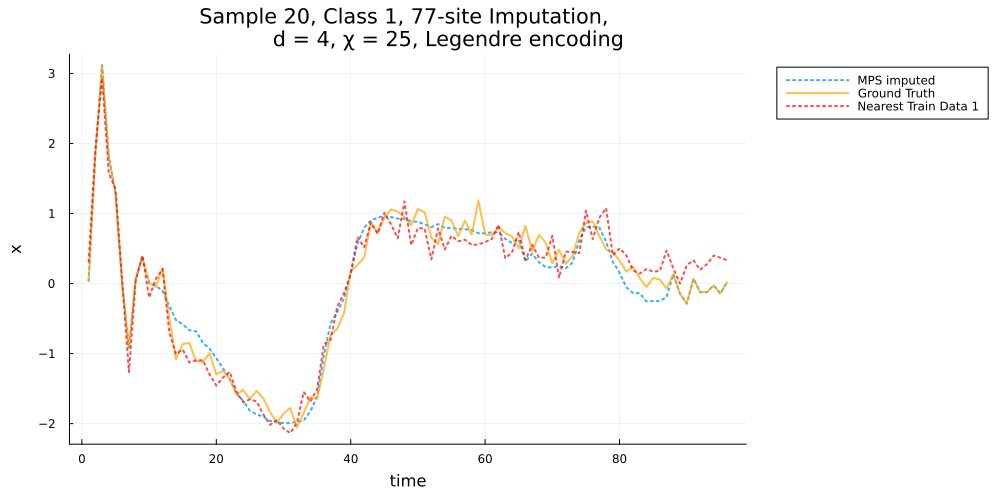

In [24]:
plot(p...)


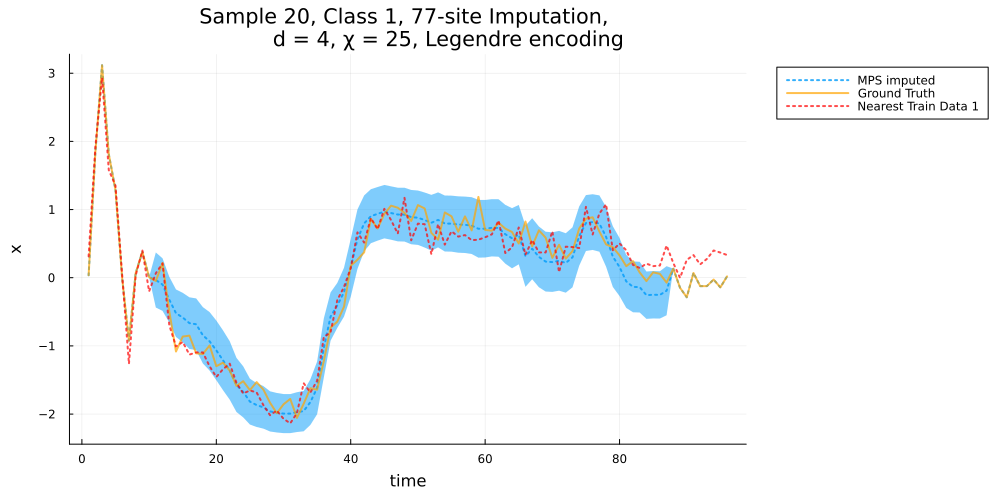

In [50]:
plot(p...)

In [3]:
using Optimization
using OptimizationBBO

In [4]:
Random.seed!(1)
@load "../test/Data/italypower/datasets/ItalyPowerDemandOrig.jld2" X_train y_train X_test y_test

params = (
    eta=(-3,1), 
    d=(10,20), 
    chi_max=(20,50),
    nsweeps=(2,8)
,) 
rs_f = jldopen("../Folds/IPD/ipd_resample_folds_julia_idx.jld2", "r");
fold_idxs = read(rs_f, "rs_folds_julia");
close(rs_f)

@load "../Folds/IPD/ipd_windows_julia_idx.jld2" windows_julia
folds = [(fold_idxs[i-1]["train"], fold_idxs[i-1]["test"]) for i in 1:30]


30-element Vector{Tuple{Vector{Int64}, Vector{Int64}}}:
 ([1, 2, 3, 4, 5, 6, 7, 8, 9, 10  …  58, 59, 60, 61, 62, 63, 64, 65, 66, 67], [68, 69, 70, 71, 72, 73, 74, 75, 76, 77  …  1087, 1088, 1089, 1090, 1091, 1092, 1093, 1094, 1095, 1096])
 ([1065, 159, 128, 870, 946, 842, 802, 84, 974, 882  …  742, 960, 351, 1012, 187, 635, 587, 481, 723, 451], [779, 1054, 338, 650, 937, 526, 888, 158, 599, 866  …  47, 760, 34, 214, 1007, 954, 162, 908, 270, 797])
 ([29, 477, 983, 868, 826, 143, 273, 724, 533, 629  …  616, 364, 240, 604, 951, 961, 759, 756, 1040, 438], [722, 1063, 98, 268, 280, 384, 166, 1051, 269, 526  …  674, 21, 298, 45, 992, 411, 401, 360, 408, 698])
 ([850, 852, 543, 373, 51, 1079, 465, 274, 988, 643  …  78, 387, 788, 713, 181, 225, 445, 380, 170, 513], [429, 873, 250, 1094, 732, 228, 637, 199, 1062, 1027  …  44, 921, 165, 868, 310, 1075, 467, 760, 630, 152])
 ([484, 185, 1054, 749, 264, 772, 120, 1060, 585, 669  …  933, 825, 607, 786, 13, 886, 694, 1014, 1068, 914], [224, 989, 96

In [8]:

evaluate(
    vcat(X_train, X_test), 
    vcat(y_train, y_test), 
    params,
    BBO_random_search(); 
    objective=ImputationLoss(), 
    opts0=MPSOptions(; verbosity=-5, log_level=-1, nsweeps=5), 
    nfolds=1, 
    n_cvfolds=0,
    eval_windows=windows_julia,
    tuning_windows = vcat(windows_julia[85], windows_julia[95]),
    tuning_abstol=1e-3, 
    tuning_maxiters=1,
    verbosity=2,
    foldmethod=folds,
    input_supertype=Float64,
    provide_x0=false,
    logspace_eta=true,
    distribute_folds=false)


Beginning fold 1:
Generating Folds
best_params = (chi_max = 25, d = 10, eta = 1.023292992280754, nsweeps = 5)
fold 1: t=0.6: training MPS with (chi_max = 25, d = 10, eta = 1.023292992280754, nsweeps = 5)...  done
 Evaluating instance 1/1029...done (4.53s)
 Evaluating instance 2/1029...done (0.85s)
 Evaluating instance 3/1029...done (0.84s)
 Evaluating instance 4/1029...done (0.87s)
 Evaluating instance 5/1029...done (0.85s)
 Evaluating instance 6/1029...done (0.85s)
 Evaluating instance 7/1029...done (0.87s)
 Evaluating instance 8/1029...done (0.87s)
 Evaluating instance 9/1029...done (0.83s)
 Evaluating instance 10/1029...done (0.85s)
 Evaluating instance 11/1029...done (0.87s)
 Evaluating instance 12/1029...done (0.85s)
 Evaluating instance 13/1029...done (0.86s)
 Evaluating instance 14/1029...done (0.84s)
 Evaluating instance 15/1029...done (0.87s)
 Evaluating instance 16/1029...done (0.84s)
 Evaluating instance 17/1029...done (0.85s)
 Evaluating instance 18/1029...done (0.84s)
 Eva

InterruptException: InterruptException:

In [16]:
PProf.refresh()

Process(`/home/noodles/.julia/artifacts/c13be74a313e5b0d58c651c54b95de63814e0057/bin/pprof -http=localhost:57599 -relative_percentages profile.pb.gz`, ProcessRunning)

Main binary filename not available.
Serving web UI on http://localhost:57599
pprof: listen tcp 127.0.0.1:57599: bind: address already in use


In [10]:
vcat(windows_julia[85], windows_julia[95])


5-element Vector{Vector{Int64}}:
 [3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22]
 [4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23]
 [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21]
 [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
 [1, 2, 3, 4, 5, 6, 7, 8, 9, 10  …  14, 15, 16, 17, 18, 19, 20, 21, 22, 23]

# Bench new

In [9]:
@load "../test/Data/italypower/datasets/ItalyPowerDemandOrig.jld2" X_train y_train X_test y_test


@load "../Folds/IPD/ipd_windows_julia_idx.jld2" windows_julia
folds = [(fold_idxs[i-1]["train"], fold_idxs[i-1]["test"]) for i in 1:30]

30-element Vector{Tuple{Vector{Int64}, Vector{Int64}}}:
 ([1, 2, 3, 4, 5, 6, 7, 8, 9, 10  …  58, 59, 60, 61, 62, 63, 64, 65, 66, 67], [68, 69, 70, 71, 72, 73, 74, 75, 76, 77  …  1087, 1088, 1089, 1090, 1091, 1092, 1093, 1094, 1095, 1096])
 ([1065, 159, 128, 870, 946, 842, 802, 84, 974, 882  …  742, 960, 351, 1012, 187, 635, 587, 481, 723, 451], [779, 1054, 338, 650, 937, 526, 888, 158, 599, 866  …  47, 760, 34, 214, 1007, 954, 162, 908, 270, 797])
 ([29, 477, 983, 868, 826, 143, 273, 724, 533, 629  …  616, 364, 240, 604, 951, 961, 759, 756, 1040, 438], [722, 1063, 98, 268, 280, 384, 166, 1051, 269, 526  …  674, 21, 298, 45, 992, 411, 401, 360, 408, 698])
 ([850, 852, 543, 373, 51, 1079, 465, 274, 988, 643  …  78, 387, 788, 713, 181, 225, 445, 380, 170, 513], [429, 873, 250, 1094, 732, 228, 637, 199, 1062, 1027  …  44, 921, 165, 868, 310, 1075, 467, 760, 630, 152])
 ([484, 185, 1054, 749, 264, 772, 120, 1060, 585, 669  …  933, 825, 607, 786, 13, 886, 694, 1014, 1068, 914], [224, 989, 96

In [22]:
windows = MPSTime.make_windows(windows_julia, nothing, X_test)
d = 20
chi_maxs = 20:10:60
# median test
method = :median

opts = MPSOptions(d=d, chi_max=chi_maxs[3], verbosity = -5)

MPSOptions(-5, 5, 40, 0.01, 20, :Legendre_No_Norm, false, 2, 1.0e-10, 1, Float64, :KLD, :TSGO, false, (false, true), false, false, false, true, false, true, 1234, 4, 3, (0.0, 1.0))

In [ ]:


mps, _... = fitMPS(X_train, y_train, opts);



Generating initial weight MPS with bond dimension χ_init = 4
        using random state 1234.
Initialising train states.
Using 1 iterations per update.
Training KL Div. 29.546059042497784 | Training acc. 0.43283582089552236.
Using optimiser CustomGD with the "TSGO" algorithm
Starting backward sweeep: [1/5]
Backward sweep finished.
Starting forward sweep: [1/5]
Finished sweep 1. Time for sweep: 5.33s
Training KL Div. -38.284192070710695 | Training acc. 1.0.
Using optimiser CustomGD with the "TSGO" algorithm
Starting backward sweeep: [2/5]
Backward sweep finished.
Starting forward sweep: [2/5]
Finished sweep 2. Time for sweep: 9.37s
Training KL Div. -40.601664379188236 | Training acc. 1.0.
Using optimiser CustomGD with the "TSGO" algorithm
Starting backward sweeep: [3/5]
Backward sweep finished.
Starting forward sweep: [3/5]
Finished sweep 3. Time for sweep: 9.15s
Training KL Div. -41.49724569669757 | Training acc. 1.0.
Using optimiser CustomGD with the "TSGO" algorithm
Starting backward

In [1]:
p_fold = 2, time(), nothing, 1

eval_loss(MPSTime.ImputationLoss(), mps, X_test, y_test, windows[1:1]; p_fold=p_fold)

UndefVarError: UndefVarError: `MPSTime` not defined in `Main`
Suggestion: check for spelling errors or missing imports.

In [20]:
windows_julia

Dict{Any, Any} with 10 entries:
  5  => [[7], [6], [11], [4], [23], [8], [2], [20], [14], [5], [22], [1], [9], …
  15 => [[9, 10, 11, 12], [11, 12, 13, 14], [4, 5, 6, 7], [19, 20, 21, 22], [5,…
  35 => [[7, 8, 9, 10, 11, 12, 13, 14], [5, 6, 7, 8, 9, 10, 11, 12], [4, 5, 6, …
  25 => [[16, 17, 18, 19, 20, 21], [3, 4, 5, 6, 7, 8], [10, 11, 12, 13, 14, 15]…
  45 => [[13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23], [11, 12, 13, 14, 15, 16,…
  55 => [[9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21], [8, 9, 10, 11, 12…
  65 => [[7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22], [4, 5, …
  95 => [[1, 2, 3, 4, 5, 6, 7, 8, 9, 10  …  14, 15, 16, 17, 18, 19, 20, 21, 22,…
  85 => [[3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, …
  75 => [[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18], [6, 7…

In [16]:
t

5